# Longevity phenotypes in mice of various ages

In this notebook we consider a [mouse study](https://www.nature.com/articles/s41467-022-34515-y) that examines how phenotypes change as mice age. 


## Data

The study data are available [here](https://data.mendeley.com/preview/ypz9zyc9rp?a=09b16f74-4581-48f7-94af-469e01757949), but you do not need to download the data directly from this link, as the script below will read a prepared version of the data.  You will need to download the data as a json file from [Github](https://github.com/kshedden/case_studies/tree/main/mouse_aging), and change the path below to point to the location of the file on your system.  

If you are curious about how the data were prepared, see the [pool.py](https://github.com/kshedden/case_studies/blob/main/mouse_aging/pool.py) Python script. Lists of all phenotypes with their abbreviations (used below) and brief descriptions of the phenotypes are in the supplementary data 2 file linked in the [paper](https://www.nature.com/articles/s41467-022-34515-y), direct link [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-022-34515-y/MediaObjects/41467_2022_34515_MOESM4_ESM.xlsx).

## Scientific aims

The overarching aim of this study is to understand how phenotypes change with age in mice, either naturalistically or following an intervention.  These are referred to as _age specific phenotypes_, or "ASPs".  The authors claim to perform "deep phenotyping", by which they mean that a large number of phenotypes (around two-hundred) are assessed. This is an open-ended exploratory study that does not test a specific pre-specified hypothesis.  The researchers considered all phenotypes in an "unbiased" manner for changes over the mouse lifespan, and in response to intervention.

This study has an [observational](https://en.wikipedia.org/wiki/Observational_study) component in which changes in some phenotypes occur naturalistically over the mouse lifespan.  It also includes an interventional component with three independent interventions: two genetic manipulations and a dietary intervention (calorie restriction).  

The authors used both univariate and multivariate methods in their study.  In univariate analyses, a single phenotype was considered in relation to age, and (if present) intervention group assignment. 

## Study design and analytic methods

This study considers phenotypic change over the mouse lifespan. Since some of the phenotypes of interest can only be assessed after sacrificing the mouse, it is implemented as a [cross sectional](https://en.wikipedia.org/wiki/Cross-sectional_study) rather than a [longitudinal](https://en.wikipedia.org/wiki/Longitudinal_study) study.  In the observational component of the study, the authors collected data at 6 distinct ages during the mouse lifespan (from 3-26 months), with around 15 independent mice assessed at each age. In the interventional component of the study, only two time points were considered.  In both cases, mice observed at different ages are mutually independent.  

The authors emphasize that at the first age (3 months) the mice are considered to be very young, and are not yet subject to any aging effects.  The effect of an intervention can be limited to the older ages, or alternatively can affect mice at all ages roughly equally.  Although both effects are interesting, the authors argue that the interventions that specifically impact older mice are more likely to translate to human therapies, or to reveal important mechanisms underlying aging.

All mice in this study are male.  Current NIH guidance strongly advocates for sex balanced designs (this study was conducted in Europe).

A large number of phenotypes are measured.  Some, such as heart rate, can be measured on a living mouse, while others such as organ weights can only be made upon sacrifice of the animal -- this is why the design is cross sectional rather than longitudinal (i.e. by making repeated measures on the same mice). The authors make a number of comments about their study design choices in the Discussion section of their paper.

An important practical consideration is whether the phenotypes approximately change linearly over time, or if the phenotype changes are more complex than can be described in linear form.  These two patterns of effects can be distinguished by considering models that are either additive, or that include a time by intervention group interaction.

We will use the following libraries in our analysis:

In [426]:
import pandas as pd
import json
import gzip
import re
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import string
import prince
from scipy.stats import distributions
from statsmodels.stats.multitest import local_fdr

The next cell loads the data from a compressed json "blob".  The data take the form of a dictionary that associates the figures of the paper with various data tables.

Each data table has two or three columns, giving the age and the recorded value for one phenotype, along with the intervention group assignment if an intervention was performed.

In [427]:
with gzip.open("mouse_data.json.gz") as gg:
    md = json.load(gg)

We can count the number of datasets present in each section of the paper.

In [428]:
{k: len(md[k]) for k in md.keys()}

{'Figure2_phenotypes': 186,
 'Figure4_phenotypes': 202,
 'Figure5_phenotypes': 157,
 'Figure2_molecularMarkers': 167,
 'Figure3_phenotypes': 206}

In [429]:
pd.read_csv(io.StringIO(md["Figure4_phenotypes"]["Food_intake_1"]), sep=",").head(10)

,age,genotype,Food_intake_1
0,young,wildtype,4.1
1,young,wildtype,3.6
2,young,wildtype,2.2
3,young,wildtype,2.1
4,young,wildtype,2.7
5,young,wildtype,1.5
6,young,wildtype,1.8
7,young,wildtype,3.4
8,young,wildtype,2.2
9,young,wildtype,4.2


Here is an example of one of the datasets (in text form):

In [430]:
md["Figure2_phenotypes"]["tibia_length"]

'age,tibia_length\n3_mo,17.85\n3_mo,18.35\n3_mo,18.22\n3_mo,17.1\n3_mo,18.04\n5_mo,18.42\n5_mo,18.13\n5_mo,18.52\n5_mo,18.77\n5_mo,18.4\n8_mo,18.97\n8_mo,19.28\n8_mo,17.64\n8_mo,18.56\n8_mo,18.61\n14_mo,18.87\n14_mo,19.04\n14_mo,18.4\n14_mo,18.64\n14_mo,18.49\n20_mo,18.32\n20_mo,18.54\n20_mo,18.27\n20_mo,18.61\n20_mo,18.62\n26_mo,18.49\n26_mo,18.06\n26_mo,18.69\n26_mo,18.61\n26_mo,18.14\n'

Here is what the data look like after extracting to a data frame:

In [431]:
pd.read_csv(io.StringIO(md["Figure2_phenotypes"]["tibia_length"]), sep=",").head(10)

,age,tibia_length
0,3_mo,17.85
1,3_mo,18.35
2,3_mo,18.22
3,3_mo,17.10
4,3_mo,18.04
5,5_mo,18.42
6,5_mo,18.13
7,5_mo,18.52
8,5_mo,18.77
9,5_mo,18.40


The study data are stored as a large collection of small datasets.  The function below extracts one dataset and does some basic preprocessing of it.

In [432]:
def get_data(dset, vname, convert_age=True, standardize=False):
  """
  Extract the data for phenotype 'vname' from data collection 'dset'.  
  If 'convert_age' is True, the age is converted to numeric values.  If
  'standardize' is True, the phenotype values are standardized to zero 
  mean and unit standard deviation.
  """
  da = pd.read_csv(io.StringIO(md[dset][vname]), sep=",")
  # Standardize the variable names since they will appear in formulas
  vname1 = vname.replace(" ", "_")
  vname1 =  "n"+vname1 if re.match("^\d", vname1) is not None else vname1 
  vname1 = vname1.translate(str.maketrans('', '', string.punctuation.replace("_", "")))
  da = da.rename({vname: vname1}, axis=1)
  da[vname1] = pd.to_numeric(da[vname1], errors="coerce")
  if convert_age:
    da["age"] = pd.to_numeric(da["age"].str.replace("_mo", ""))
  if standardize:
    da[vname1] = (da[vname1] - da[vname1].mean()) / da[vname1].std()
  return vname1, da.dropna()

Here is what the data look like after pre-processing:

In [433]:
get_data("Figure2_phenotypes", "tibia_length")[1]

,age,tibia_length
0,3,17.85
1,3,18.35
2,3,18.22
3,3,17.10
4,3,18.04
5,5,18.42
6,5,18.13
7,5,18.52
8,5,18.77
9,5,18.40


We also have the option to convert the measurements to Z-scores:

In [434]:
get_data("Figure2_phenotypes", "tibia_length", standardize=True)[1].head(10)

,age,tibia_length
0,3,-1.341633
1,3,-0.168193
2,3,-0.473287
3,3,-3.101793
4,3,-0.895726
5,5,-0.003911
6,5,-0.684507
7,5,0.230777
8,5,0.817497
9,5,-0.050849


In [435]:
get_data("Figure2_phenotypes", "Glucose_fasting", standardize=True)[1]

,age,Glucose_fasting
0,3,0.797376
1,3,-0.250369
2,3,0.812561
3,3,0.038140
4,3,0.174803
...,...,...
80,26,-1.503108
81,26,-1.411999
82,26,-0.159261
83,26,-1.609401


In [436]:
get_data("Figure2_phenotypes", "Glucose_conc_0_1")[1]

,age,Glucose_conc_0_1
0,3,9.38
1,3,8.83
2,3,9.94
3,3,13.49
4,3,12.43
...,...,...
79,26,10.49
80,26,6.44
81,26,7.60
82,26,9.88


In [437]:
get_data("Figure2_phenotypes", "Fat_mass_NMR")[1]

,age,Fat_mass_NMR
0,3,6.7
1,3,6.1
2,3,7.0
3,3,9.6
4,3,9.4
...,...,...
80,26,7.2
81,26,5.3
82,26,7.7
83,26,8.0


In [438]:
get_data("Figure2_phenotypes", "conc_Insulin", standardize=True)[1]

,age,conc_Insulin
0,3,-0.408928
1,3,-0.701454
2,3,-0.090439
3,3,0.571243
4,3,0.521408
...,...,...
61,26,1.914778
62,26,-0.442062
63,26,0.438173
64,26,0.790469


# Analysis of observational data

## Visualization

As a form of [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis), the next cell uses [boxplots](https://en.wikipedia.org/wiki/Box_plot) to visualize a few of the phenotypes from the "figure 2" set of experimental results (this is an observational component of the study, looking at associations between age and naturally-varying phenotypes).  We also print a frequency table for the number of observations (independent mice) at each age in each dataset.  

The boxplots reflect one of the primary research aims of the study, which is to identify age-related changes in phenotypes.  The median line in each box should follow the trajectory of age-related change for each phenotype, and the widths of the boxes should reflect the degree of dispersion around the central value.

     Glucose_fasting
age                 
3                 15
5                 14
8                 14
14                14
20                15
26                13
     conc_Insulin
age              
3              11
5              13
8              12
14             12
20              9
26              9
     Fat_mass_NMR
age              
3              15
5              14
8              14
14             14
20             15
26             13


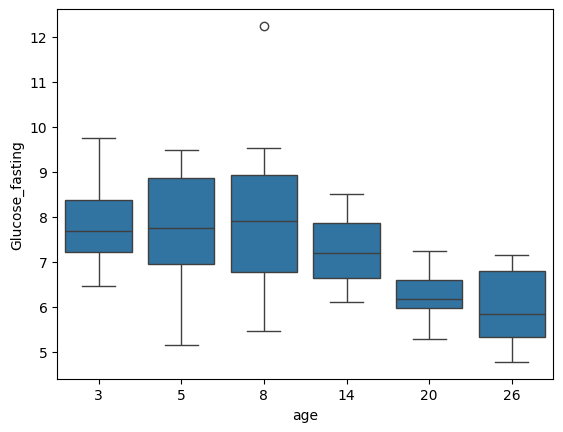

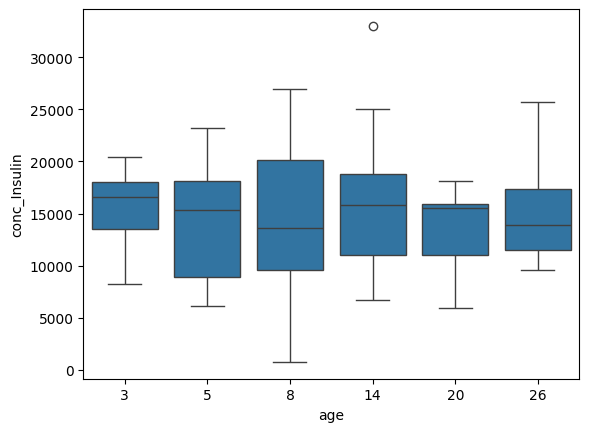

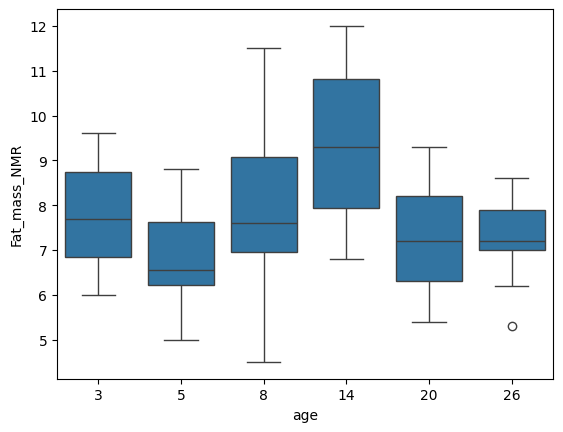

In [439]:
for vname in ["Glucose_fasting", "conc_Insulin", "Fat_mass_NMR"]:
  _, da = get_data("Figure2_phenotypes", vname)
  c = da.groupby("age").count().sort_index()
  print(c)
  plt.figure()
  sns.boxplot(da, x="age", y=vname)

## Formal statistical analyses

In their paper, the authors claim that 59% of phenotypes have a [statistically significant](https://en.wikipedia.org/wiki/Statistical_significance) association with age.  The underlying analysis uses a nonparametric one-way ANOVA procedure ([Kruskal-Wallis](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test)) for (semi) quantitative phenotypes, and [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) for binary phenotypes.  Below we do a simplified version of this analysis, using for simplicity the Kruskal-Wallis ANOVA procedure for all phenotypes.  This analysis does not impose a mean structure model, such as assuming linear change of the phenotype with age.

The results are quite similar to those reported in the publication (57% versus 59%).

In [440]:
n0, n1 = 0, 0
nobs = []
for vname in md["Figure2_phenotypes"].keys():
  vname1, da = get_data("Figure2_phenotypes", vname)
  ga = da.groupby("age").groups
  dx = [da[vname1][g].values for g in ga.values()]
  kr = stats.kruskal(*dx)
  n0 += 1
  n1 += kr.pvalue < 0.05
  nobs.append(da.shape[0])
(n0, n1, n1/n0)

(186, np.int64(107), np.float64(0.5752688172043011))

The graph below shows the distribution of the number of observations (across all ages) per phenotype.

np.float64(75.0)

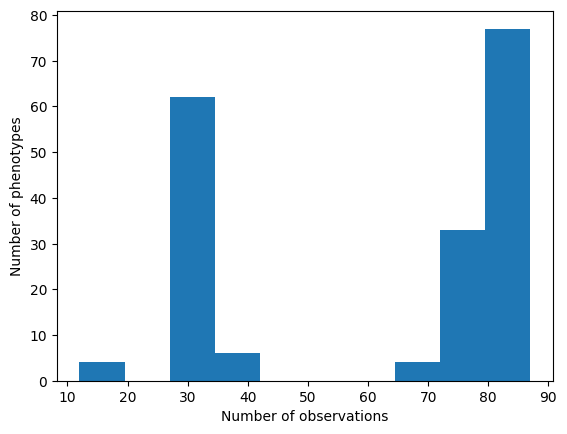

In [441]:
nobs = np.asarray(nobs)
plt.hist(nobs)
plt.xlabel("Number of observations")
plt.ylabel("Number of phenotypes")
np.median(nobs)

We can also assess for relationships using Pearson correlation.  This approach is more sensitive to linear change but is completely unable to detect "U-shaped" relationships.  In this case the results of the Pearson correlation analysis are almost identical to the results of the "nonparametric" approach.

In [442]:
n0, n1 = 0, 0
for vname in md["Figure2_phenotypes"].keys():
  vname1, da = get_data("Figure2_phenotypes", vname)
  r = np.corrcoef(da["age"], da[vname1])[0,1]
  se = 1/np.sqrt(da.shape[0])
  n0 += 1
  n1 += np.abs(r) > 2*se
(n0, n1, n1/n0)

(186, np.int64(105), np.float64(0.5645161290322581))

We can take a [large scale inference](https://www.cambridge.org/core/books/largescale-inference/A0B183B0080A92966497F12CE5D12589) perspective and consider how the Kruskal-Wallis and Pearson correlation approaches relate across the large collection of phenotypes considered here.

<Axes: xlabel='KWZ', ylabel='PCZ'>

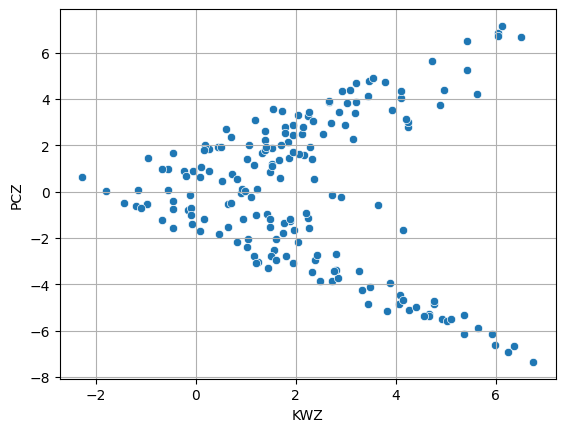

In [443]:
rr = []
for vname in md["Figure2_phenotypes"].keys():
  vname1, da = get_data("Figure2_phenotypes", vname)

  # Kruskal-Wallis analysis
  ga = da.groupby("age").groups
  dx = [da[vname1][g].values for g in ga.values()]
  kr = stats.kruskal(*dx)
    
  # Convert the Kruskal-Wallis statistic to a Z-score
  ng = len(ga.values()) # number of age groups
  zstat = distributions.norm().ppf(distributions.chi2(ng-1).cdf(kr.statistic))

  # Pearson correlation analysis
  r = np.corrcoef(da["age"], da[vname1])[0,1]
  se = 1/np.sqrt(da.shape[0])
    
  rr.append([vname1, kr.statistic, kr.pvalue, zstat, r/se])

rr = pd.DataFrame(rr, columns=["pheno", "KWstat", "KWpval", "KWZ", "PCZ"])

plt.grid(True)
sns.scatterplot(rr, x="KWZ", y="PCZ")

In [444]:
rr.head()

,pheno,KWstat,KWpval,KWZ,PCZ
0,CD8_CD44_62L_6C_NNN,3.131819,0.679672,-0.466780,1.647972
1,Food_intake_1,1.718442,0.886568,-1.208478,-0.634454
2,CD4_Ly6C,17.745883,0.003282,2.718157,-3.862958
3,NEFA_fasting,5.175040,0.394894,0.266586,1.827673
4,QT_dispersion,5.182365,0.394032,0.268825,0.899009


These are the phenotypes that have strong evidence for differences under the Kruskal-Wallis analysis and minimal evidence for differences under the Pearson correlation analysis.

Fat_mass_NMR
Fract_shortening
Cl
MCV
Non_HDL_chol_fasting


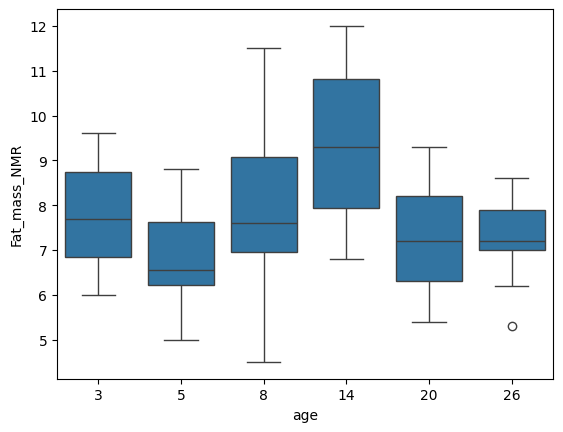

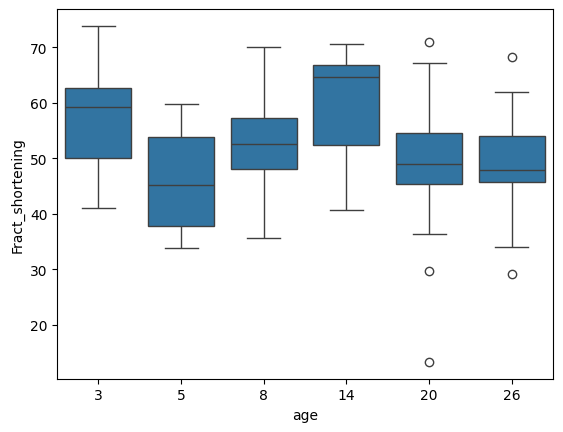

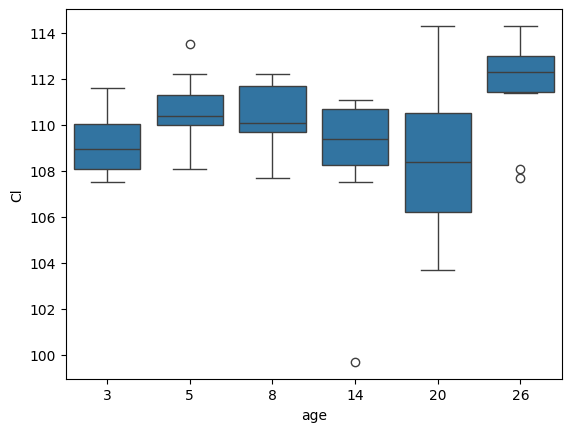

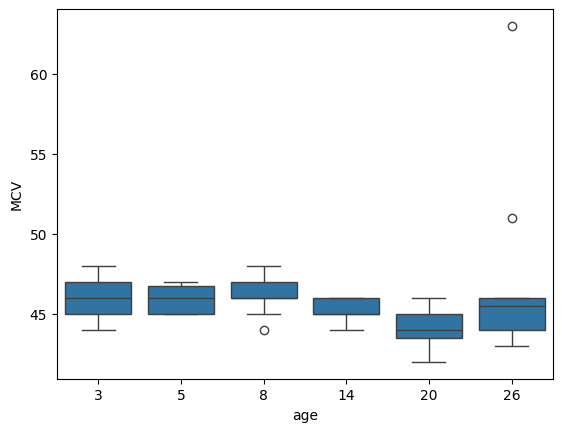

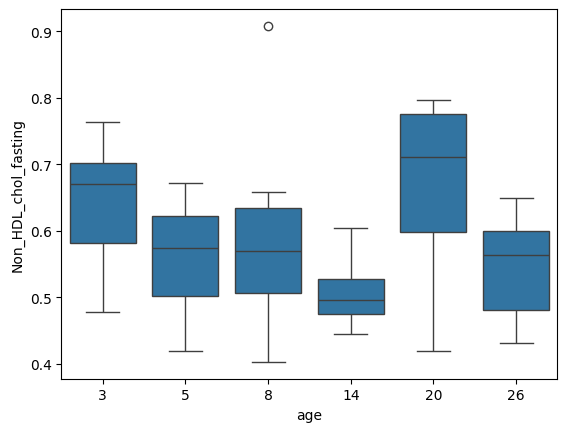

In [445]:
ii = (rr.KWZ > 2) & (np.abs(rr.PCZ) < 1) 
rq = rr[ii]
for vname in rq["pheno"]:
    _, da = get_data("Figure2_phenotypes", vname)
    plt.figure()
    sns.boxplot(da, x="age", y=vname)
for vname in rq["pheno"]:
    print(vname)

Although 107 (around 58%) of the phenotypes show age dependence based on having a p-value smaller than 0.05, this set potentially includes many false positives since we are testing multiple hypotheses.  The traditional way to address this is to control the Family-Wise Error Rate (FWER).  The Bonferroni method achieves this and is easy to use.  However it can be quite conservative when the data corresponding to different hypotheses are not independent.  As shown below, if we control the FWER, then less than half of the phenotypes remain "significant".

In [446]:
ntest = rr.shape[0]
print((rr["KWpval"] < 0.05).sum())
print((rr["KWpval"] < 0.05/ntest).sum())
print((ntest*rr["KWpval"] < 0.05).sum())

107
45
45


False Discovery Rates (FDR) are a popular method to assess the results of large numbers of hypothesis tests.  The FDR is calculated at a threshold t, and considers a hypothesis to be a "discovery" if its test statistic exceeds t (usually we do two-sided analysis, so we consider whether the magnitude of the test statistic exceeds t).  The FDR is the proportion of discoveries that are false, so the number of discoveries belongs in the denominator of the FDR, and the numerator of the FDR is an estimate of the number of false discoveries that would be made for a given number of tests m and a given test statistic threshold t.  If our test statistic is a Z-score and follows a standard normal distribution under the null, this numerator can be easily estimated (or bounded).

Below we calculate FDR values for a series of thresholds t.  These FDR values pertain to the null hypothesese that each phenotype is unrelated to age (i.e. follows the same distribution at each age).  We use as a conservative estimator the ratio of the expected number of false discoveries to the number of discoveries.  

In [447]:
for t in [1, 2, 3, 4, 5, 10]:
    n_expected = rr.shape[0]*(1 - stats.norm.cdf(t))
    n_observed = (rr["KWZ"] > t).sum()
    fdr = n_expected / n_observed
    print([t, n_expected, n_observed, fdr])

[1, np.float64(29.509877231251014), np.int64(137), np.float64(0.21540056373175923)]
[2, np.float64(4.231524542361333), np.int64(89), np.float64(0.04754521957709363)]
[3, np.float64(0.25108103388319924), np.int64(56), np.float64(0.0044835898907714155)]
[4, np.float64(0.005890850980960316), np.int64(38), np.float64(0.00015502239423579778)]
[5, np.float64(5.3317192377777545e-05), np.int64(17), np.float64(3.1363054339869146e-06)]
[10, np.float64(0.0), np.int64(0), np.float64(nan)]


/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_43981/710889850.py:4: RuntimeWarning: invalid value encountered in scalar divide
  fdr = n_expected / n_observed


Efron devised the "local" false discovery rate which is the ratio of the density of observed statistics to its null density.  The local FDR is $p_0f_0(z)/f(z)$, where $p_0$ is the proportion of true null hypotheses, $f_0$ is the density of null Z-scores, and $f$ is the density of observed Z-scores.  A conservative estimate of the local FDR is obtained by setting $p_0=1$.  In the next cell we estimate $f$ using a histogram and assume that $f_0$ is standard normal.

Text(0, 0.5, 'Density')

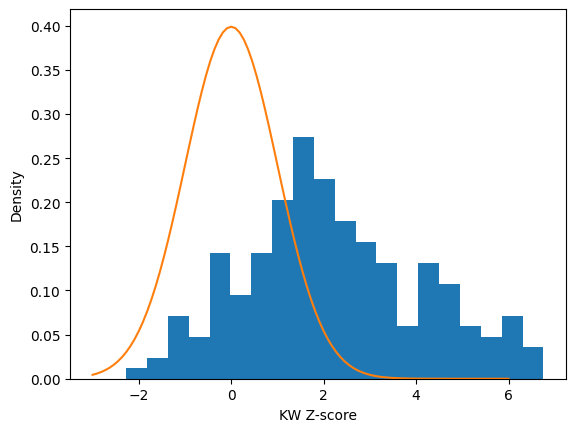

In [448]:
plt.hist(rr["KWZ"], bins=20, density=True);
x = np.linspace(-3, 6, 100)
y = np.exp(-x**2/2)/np.sqrt(2*np.pi)
plt.plot(x, y, "-")
plt.xlabel("KW Z-score")
plt.ylabel("Density")

The actual local FDR approach uses "Lindsey's method" instead of a histogram to estimate $f$.  There is also an "empirical null" strategy that allows the data to inform the value of $f_0$, but we do not consider that further here.  Below we see that under the standard of local FDR, we can be confident that 63 of the phenotypes are age-specific.  This is modestly more than under FWER control.

In [449]:
lfdr = local_fdr(rr["KWZ"])
np.sum(lfdr < 0.05)

np.int64(63)

In [450]:
age_sig = rr.loc[lfdr < 0.05, "pheno"].tolist()
age_sig

['CD8_CD44_62L_6C_PPP',
 'HR',
 'NbRear05',
 'Glucose_fasting',
 'PcPPI_PP81',
 'free_fluid',
 'Gluc',
 'PLCR',
 'CD4_CD62L',
 'Av_body_surface_temp',
 'IgM',
 'alpha_Amylase_CNPG3',
 'CD8_CD44',
 'DisT05',
 'Fat_mass_NMR',
 'PcPPI_PP69',
 'NK',
 'Glucose_conc_0_1',
 'Ca',
 'WholeAverSpeed',
 'CD4',
 'PLT',
 'Lean_mass_NMR',
 'eu_loco_activity',
 'Urea',
 'Total_chol_fasting',
 'PcPPI_PP67',
 'UIBC',
 'Resp_Rate_Echo',
 'NRTot',
 'K',
 'conc_IL6',
 'MCH',
 'Ekrea',
 'Na',
 'Albumin',
 'QRS',
 'PcPPI_PP73',
 'RR',
 'TG_fasting',
 'RBC',
 'AP',
 'Body_mass_NMR',
 'HDL_fasting',
 'conc_TNF',
 'HCT',
 'CD4_CD44_62L_6C_PNN',
 'DisTTot',
 'HGB',
 'ST110',
 'Spleen_weight',
 'eu_2nd_response_time',
 'CD8',
 'PcPPI_Global',
 'CD4_CD44_62L_6C_NNN',
 'rethi_avg_ri_le',
 'eu_gait',
 'eu_startle_response',
 'Rod_mean',
 'eu_limb_grasp',
 'Kidney_weight',
 'Non_HDL_chol_fasting',
 'MPV']

The following plot shows the relationship between the Kruskal-Wallis Z-score and the local FDR, which is specific to this dataset.

Text(0, 0.5, 'Local FDR')

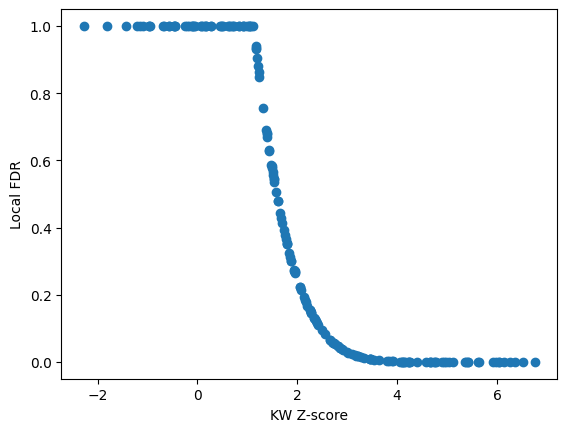

In [451]:
plt.plot(rr["KWZ"], lfdr, "o")
plt.xlabel("KW Z-score")
plt.ylabel("Local FDR")

## Analysis of interventional data

Now we turn to diet, which is one of the interventional components of the study.  Mice were on either a calorie-restricted or regular diet.  In these experiments, there were two age groups denoted "young" and "old".

We begin by using boxplots to explore the distributions for a few phenotypes.

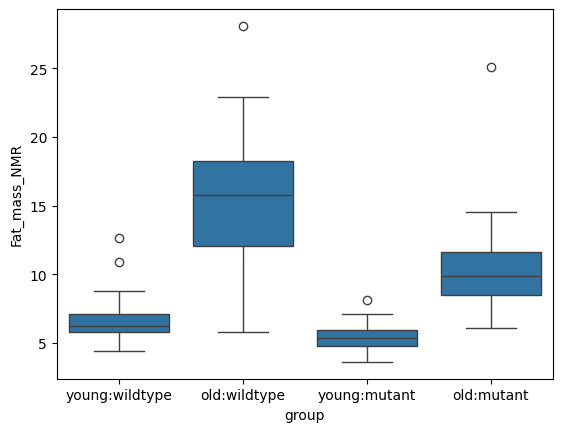

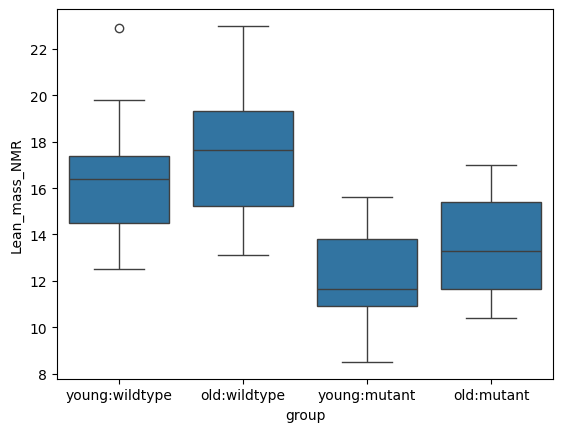

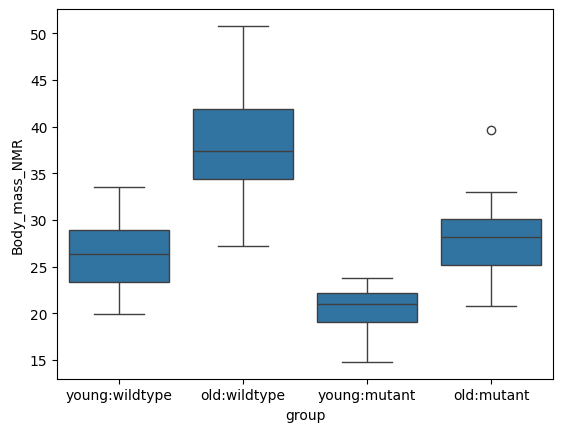

In [452]:
for vname in ["Fat_mass_NMR", "Lean_mass_NMR", "Body_mass_NMR"]:
    vname1, da = get_data("Figure4_phenotypes", vname, convert_age=False, standardize=False)
    da["group"] = ["%s:%s" % (a, b) for a,b in zip(da["age"], da["genotype"])]
    plt.figure()
    sns.boxplot(da, x="group", y=vname1)

For more formal analysis, we can use [regression](https://en.wikipedia.org/wiki/Regression_analysis) and [analysis of variance](https://en.wikipedia.org/wiki/Analysis_of_variance) to consider the combined association of age and diet type in relation to each phenotype.  Here we use [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) to fit the models since we want effect estimates and not only significance levels.  We fit a "saturated" model for each phenotype, which has an intercept, main effects for age and diet, and an [interaction](https://en.wikipedia.org/wiki/Interaction_(statistics)) between age and diet.  

In interpreting the results of the analysis, we consider the evidence for additive and non-additive associations between the intervention variable (diet) and the outcome phenotype.  Age is either a [nuisance variable](https://en.wikipedia.org/wiki/Nuisance_variable) or a [moderator](https://en.wikipedia.org/wiki/Moderation_(statistics)) (also known as a _modifier_).  

Since age and diet happen to both be binary here, this is a _two-way ANOVA_, specifically a _2x2 layout_.  The additive model can be parameterized in three degrees of freedom and the non-additive model has four degrees of freedom.  We focus on two [Wald tests](https://en.wikipedia.org/wiki/Wald_test) - one testing for an additive contribution of diet, and one testing for non-additivity of the age and diet effects.  We have minimal interest in the main effect of age so do not formally test that effect below.

There are over 200 phenotypes so we first calculate all of the relevant statistics and store them in a dataframe.

In [453]:
anovas, models, vnames, prev = {}, {}, [], []
for vname in md["Figure4_phenotypes"].keys():
    vname1, da = get_data("Figure4_phenotypes", vname, convert_age=False, standardize=True)
    mm = sm.OLS.from_formula("%s ~ age * genotype" % vname1, da)
    rr = mm.fit()
    mx = rr.model.exog
    _,s,_ = np.linalg.svd(mx,0)
    if s[0]/s[-1] > 100000:
        print("Skipping %s" % vname)
        continue
    aa = anova_lm(rr)
    anovas[vname1] = aa
    models[vname1] = rr
    vnames.append(vname1)
    prev.append([(da["age"] == "young").mean(), (da["genotype"]=="wildtype").mean()])

Here is the result of one of the model fits above, specifically that for the heart rate (HR) phenotype.  The notation "T.young" indicates that this is the coefficient estimate for the indicator of a mouse being young, which (implicitly) tells us that the reference level for the age variable is "old". Similarly, the diet coefficient corresponds to the "restricted" diet and the reference level is "control" (an _ad lib_ diet).

In [454]:
models["HR"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HR   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     8.627
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           4.91e-05
Time:                        15:06:24   Log-Likelihood:                -108.32
No. Observations:                  85   AIC:                             224.6
Df Residuals:                      81   BIC:                             234.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.2540      0.229     -1.110      0.270      -0.709       0.201
age[T.young]                          0.9799      0.303      3.236      0.002       0.377       1.582
genotype[T.wildtype]                 -0.3366      0.292     -1.154      0.252      -0.917       0.244
age[T.young]:genotype[T.wildtype]    -0.2560      0.393     -0.651      0.517      -1.038       0.527
==============================================================================
Omnibus:                       19.296   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.602
Skew:                          -0.490   Prob(JB):                     6.32e-17
Kurtosis:                       7.484   Cond. No.                         7.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The next cell organizes all of the regression findings into a dataframe.  This dataframe has one row for each phenotype.

In [455]:
zscores = [models[v].params / models[v].bse for v in vnames]
young_main = [models[v].params["age[T.young]"] for v in vnames]
young_main_z = [z["age[T.young]"] for z in zscores]
young_main_se = [models[v].bse["age[T.young]"] for v in vnames]
wild_main = [models[v].params["genotype[T.wildtype]"] for v in vnames]
wild_main_z = [z["genotype[T.wildtype]"] for z in zscores]
wild_main_se = [models[v].bse["genotype[T.wildtype]"] for v in vnames]
interaction = [models[v].params["age[T.young]:genotype[T.wildtype]"] for v in vnames]
interaction_z = [z["age[T.young]:genotype[T.wildtype]"] for z in zscores]
interaction_se = [models[v].bse["age[T.young]:genotype[T.wildtype]"] for v in vnames]
nobs = [models[v].nobs for v in vnames]
prev = np.asarray(prev)

effects = pd.DataFrame({"Variable": vnames,
                        "nobs": nobs,
                        "young_main": young_main, 
                        "young_main_z": young_main_z,
                        "young_main_se": young_main_se,
                        "wild_main": wild_main, 
                        "wild_main_z": wild_main_z,
                        "wild_main_se": wild_main_se,
                        "interaction": interaction, 
                        "interaction_z": interaction_z,
                        "interaction_se": interaction_se,
                        "age_sd": np.sqrt(prev[:, 0] * (1 - prev[:, 0])),
                        "geno_sd": np.sqrt(prev[:, 1] * (1 - prev[:, 1]))})

# Standardized effects
effects["young_main_s"] = effects["young_main"] * effects["age_sd"]
effects["wild_main_s"] = effects["wild_main"] * effects["geno_sd"]
effects["wild_main_s_se"] = effects["wild_main_se"] * effects["geno_sd"]
effects["interaction_s"] = effects["interaction"] * effects["age_sd"] * effects["geno_sd"]
effects["interaction_s_se"] = effects["interaction_se"] * effects["age_sd"] * effects["geno_sd"]

In [456]:
targets = [
   "Fat_mass_NMR",
   "Lean_mass_NMR",
   "Body_mass_NMR",
   "Glucose_fasting",
   "TG_fasting",
   "Total_chol_fasting",
   "HDL_fasting",
   "Albumi",
   "Kidney_weight",
   "Spleen_weight"
]

effects = effects[effects["Variable"].isin(targets)].reset_index(drop=True)
effects

,Variable,nobs,young_main,young_main_z,young_main_se,wild_main,wild_main_z,wild_main_se,interaction,interaction_z,interaction_se,age_sd,geno_sd,young_main_s,wild_main_s,wild_main_s_se,interaction_s,interaction_s_se
0,Glucose_fasting,82.0,-0.508377,-1.433848,0.354554,0.294602,0.935757,0.314828,0.487778,1.095555,0.445234,0.500000,0.481669,-0.254188,0.141901,0.151643,0.117474,0.107228
1,Fat_mass_NMR,86.0,-0.997088,-4.466618,0.223231,0.855368,4.036566,0.211905,-0.613748,-2.125930,0.288696,0.499459,0.491270,-0.498004,0.420217,0.104103,-0.150595,0.070837
2,Lean_mass_NMR,86.0,-0.460639,-1.782808,0.258378,1.233778,5.030310,0.245269,0.001017,0.003043,0.334151,0.499459,0.491270,-0.230070,0.606119,0.120493,0.000249,0.081990
3,Total_chol_fasting,82.0,0.471336,1.318697,0.357425,-0.248890,-0.784209,0.317377,0.061725,0.137521,0.448839,0.500000,0.481669,0.235668,-0.119882,0.152871,0.014865,0.108096
4,TG_fasting,82.0,0.142791,0.399080,0.357802,-0.567599,-1.786524,0.317711,0.322151,0.716988,0.449311,0.500000,0.481669,0.071396,-0.273395,0.153032,0.077585,0.108210
5,Body_mass_NMR,86.0,-0.976144,-5.297532,0.184264,1.271045,7.266650,0.174915,-0.489455,-2.053928,0.238302,0.499459,0.491270,-0.487544,0.624427,0.085930,-0.120097,0.058472
6,HDL_fasting,82.0,0.491894,1.385813,0.354950,-0.254139,-0.806331,0.315179,0.111480,0.250106,0.445730,0.500000,0.481669,0.245947,-0.122411,0.151812,0.026848,0.107347
7,Spleen_weight,81.0,0.050980,0.183810,0.277353,1.504375,5.575851,0.269802,-0.644984,-1.782953,0.361751,0.498129,0.493518,0.025395,0.742437,0.133152,-0.158560,0.088931
8,Kidney_weight,82.0,-0.900863,-3.263594,0.276034,0.811849,3.047550,0.266394,0.063513,0.177188,0.358448,0.498660,0.492659,-0.449224,0.399964,0.131241,0.015603,0.088060


Map the t-scores to z-scores.

In [457]:
for v in ["young_main_z", "wild_main_z", "interaction_z"]:
    dof = effects["nobs"] - 4
    effects[v] = stats.distributions.norm().ppf(stats.distributions.t(df=dof).cdf(effects[v]))

In [458]:
effects

,Variable,nobs,young_main,young_main_z,young_main_se,wild_main,wild_main_z,wild_main_se,interaction,interaction_z,interaction_se,age_sd,geno_sd,young_main_s,wild_main_s,wild_main_s_se,interaction_s,interaction_s_se
0,Glucose_fasting,82.0,-0.508377,-1.419984,0.354554,0.294602,0.930164,0.314828,0.487778,1.087887,0.445234,0.500000,0.481669,-0.254188,0.141901,0.151643,0.117474,0.107228
1,Fat_mass_NMR,86.0,-0.997088,-4.213140,0.223231,0.855368,3.843553,0.211905,-0.613748,-2.091124,0.288696,0.499459,0.491270,-0.498004,0.420217,0.104103,-0.150595,0.070837
2,Lean_mass_NMR,86.0,-0.460639,-1.760527,0.258378,1.233778,4.682157,0.245269,0.001017,0.003034,0.334151,0.499459,0.491270,-0.230070,0.606119,0.120493,0.000249,0.081990
3,Total_chol_fasting,82.0,0.471336,1.307246,0.357425,-0.248890,-0.780167,0.317377,0.061725,0.137073,0.448839,0.500000,0.481669,0.235668,-0.119882,0.152871,0.014865,0.108096
4,TG_fasting,82.0,0.142791,0.397600,0.357802,-0.567599,-1.763002,0.317711,0.322151,0.713521,0.449311,0.500000,0.481669,0.071396,-0.273395,0.153032,0.077585,0.108210
5,Body_mass_NMR,86.0,-0.976144,-4.898253,0.184264,1.271045,6.365926,0.174915,-0.489455,-2.022075,0.238302,0.499459,0.491270,-0.487544,0.624427,0.085930,-0.120097,0.058472
6,HDL_fasting,82.0,0.491894,1.372996,0.354950,-0.254139,-0.802086,0.315179,0.111480,0.249256,0.445730,0.500000,0.481669,0.245947,-0.122411,0.151812,0.026848,0.107347
7,Spleen_weight,81.0,0.050980,0.183194,0.277353,1.504375,5.094219,0.269802,-0.644984,-1.759250,0.361751,0.498129,0.493518,0.025395,0.742437,0.133152,-0.158560,0.088931
8,Kidney_weight,82.0,-0.900863,-3.149732,0.276034,0.811849,2.952862,0.266394,0.063513,0.176604,0.358448,0.498660,0.492659,-0.449224,0.399964,0.131241,0.015603,0.088060


### Visualization of Z-scores

The function below creates a dot-plot of the statistically standardized effects for each phenotype, considering one particular term in the model (i.e. one of the two main effects, or the interaction).  These "statistically standardized effects" are point estimates divided by the corresponding standard errors.  

The vertical lines correspond to commonly-applied decision thresholds for Z-scores.  The dashed lines correspond to a "nominal" threshold corresponding to an unadjusted p-value being less than 0.05. The dotted lines correspond to thesholds corrected for multiple hypothesis testing using the [Bonferroni method](https://en.wikipedia.org/wiki/Bonferroni_correction), which controls the family-wise coverage rate.

In [459]:
def gen_anova_z_plot(term):

  # Set up the plot
  plt.figure().set_figheight(5)
  plt.yticks(fontsize=8);
  plt.axvline(x=0, color="grey")

  sns.stripplot(data=effects.sort_values(term), y="Variable", x=term)

  # Multiplier for confidence intervals with 95% simultaneous (family-wise) coverage. 
  t = stats.distributions.norm().ppf(1 - 0.025/effects.shape[0])
    
  plt.axvline(x=-t, color="grey", ls="dotted")
  plt.axvline(x=t, color="grey", ls="dotted")
    
  # 95% CI's (no consideration of multiple coverage)
  plt.axvline(x=-2, color="grey", ls="dashed")
  plt.axvline(x=2, color="grey", ls="dashed")

The plot below shows the Z-scores for the diet main effect with respect to each phenotype.  Since there is an interaction term in the model, these effects correspond to the difference between diet groups (restricted minus control) when fixing age at "old" (the reference level of age).

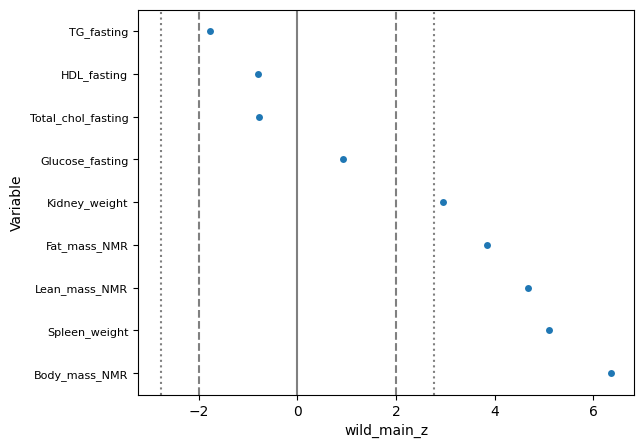

In [460]:
gen_anova_z_plot("wild_main_z")

The plot below shows the estimated interaction effects for each phenotype.  These interaction terms can be interpreted as the difference between the diet effect (restricted minus control) in the old age group and the same difference in the young age group.  That is, it is a "difference of differences".  Note that none of them reach the threshold required for [family-wise](https://en.wikipedia.org/wiki/Family-wise_error_rate) error control.  This is consistent with the authors' claims that interventions seldom change the rate of change of phenotypes with respect to aging, although some of the phenotypes do change their overall level in response to the intervention.

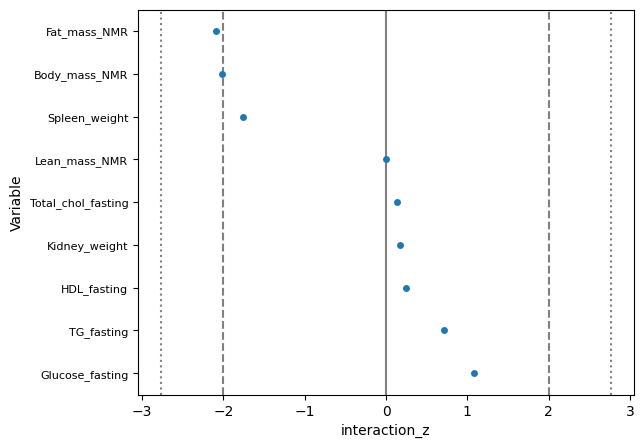

In [461]:
gen_anova_z_plot("interaction_z")

### Visualization of standardized effects

Next we visualize the same effects using a different approach.  A "standardized effect" refers here to the effect of one covariate relative to its standard deviation (above we considered Z-scores which are the effects relative to their [standard error](https://en.wikipedia.org/wiki/Standard_error)). Standardized effects are a measure of the [size of an effect](https://en.wikipedia.org/wiki/Effect_size), not its statistical significance.  In order to convey information about statistical significance in these plots, we also include 95% [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) (adjusted for multiple comparisons) for each standardized effect.  In the plots below, the orange dots are the point estimates and the blue dots are the lower and upper limits of 95% confidence intervals.

Z-scores are dimension free, meaning that their values are unaffected by rescaling either the independent of dependent variables.  Standardized effects are dimension-free with respect to rescaling of the covariate but not with respect to the outcome.  However here we have Z-scored the outcomes so the standardized effects are also dimension free.  In these data, the age covariate is quantitative, but it can only take on two distinct values.  The diet variable is categorical, but has been dummy-coded.  We can present standardized effects for covariates that are binary indicators, but it is important to remember that the standardization is with respect to the frequency of the categories, not with respect a quantitatively measured value.

In [462]:
def gen_anova_seffect_plot(term):
  plt.figure().set_figheight(5)
  ee = effects.copy()
  t = stats.distributions.norm().ppf(1 - 0.025/effects.shape[0])
  ee["lcb"] = ee[term] - t*ee["%s_se" % term]
  ee["ucb"] = ee[term] + t*ee["%s_se" % term]
  ee = ee[["Variable", "lcb", "ucb", term]]
  ee = ee.set_index("Variable").stack().reset_index()
  ee.columns = ["Variable", "hue", term]
  ee["hue"] = ee["hue"].replace({"lcb": "cb", "ucb": "cb"})
  ee = ee.sort_values(term)
  sns.stripplot(data=ee, y="Variable", x=term, hue="hue")
  plt.axvline(x=0, color="grey")
  plt.gca().legend().set_visible(False)

First we plot the standardized main effects and their 95% confidence intervals.  These are the main effects (or "simple effects") for genotype (wildlife minus mutant) in the older mice. 

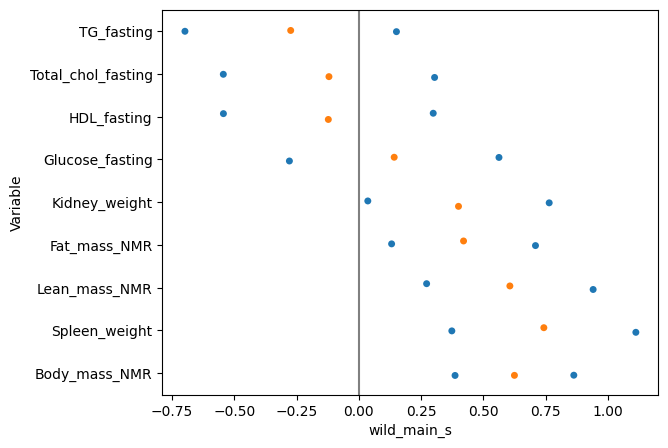

In [477]:
gen_anova_seffect_plot("wild_main_s")

Next we look at standardized "difference of differences", none of which are significantly different from zero.

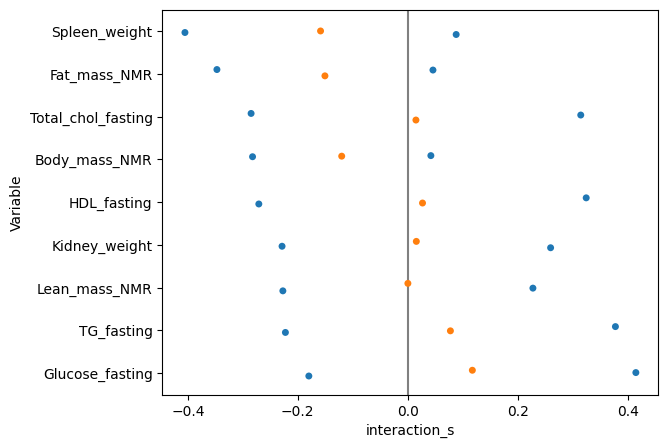

In [464]:
gen_anova_seffect_plot("interaction_s")

## Multivariate analyses

Next we use principal component analysis and biplots to undestand the joint behavior of the phenotypes in aging mice.

First we create a function that creates a single dataframe containing all phenotypes.  These are the phenotypes from the observational component of the study that are shown in figure 2 of the paper.  Since there are repeated observations (multiple independent mice) for each phenotype at each age, we summarize the repeated values here, using the mean and the standard deviation.

In [465]:
def get_all_data(dset):
    ages, pheno_mean, pheno_sd = [], [], []
    kyx = md[dset].keys()
    for k in kyx:
        vname, da = get_data(dset, k, standardize=True)
        da = da.sort_values("age")
        dg = da.groupby("age")[da.columns[1]].agg([np.mean, np.std])
        ages.append(dg.index)
        pheno_mean.append(dg["mean"].values)
        pheno_sd.append(dg["std"].values)
    ages = ages[0]
    d1 = np.vstack(pheno_mean)
    d2 = np.vstack(pheno_sd)
    d1 = pd.DataFrame(d1, index=kyx, columns=["%d_mn" % a for a in ages])
    d2 = pd.DataFrame(d2, index=kyx, columns=["%d_sd" % a for a in ages])
    return pd.concat((d1, d2), axis=1)

Below is an analogous function for the interventional data:

In [466]:
def get_all_data_intervention(dset):
    ages, diets, pheno_mean, pheno_sd = [], [], [], []
    kyx = md[dset].keys()
    for k in kyx:
        vname, da = get_data(dset, k, convert_age=False, standardize=True)
        da = da.sort_values("age")
        dg = da.groupby(["age", "genotype"])[da.columns[2]].agg([np.mean, np.std])
        dg = dg.reset_index()
        dg = dg.sort_values(["age", "genotype"])
        ages.append(dg["age"])
        diets.append(dg["genotype"])
        pheno_mean.append(dg["mean"].values)
        pheno_sd.append(dg["std"].values)
    ages = ages[0]
    diets = diets[0]
    d1 = np.vstack(pheno_mean)
    d2 = np.vstack(pheno_sd)
    cols = ["%s_%s_mn" % (x, y) for (x, y) in zip(ages, diets)]
    d1 = pd.DataFrame(d1, index=kyx, columns=cols)
    cols = ["%s_%s_sd" % (x, y) for (x, y) in zip(ages, diets)]
    d2 = pd.DataFrame(d2, index=kyx, columns=cols)
    return pd.concat((d1, d2), axis=1)

Below are the aggregated summary statistics for the interventional study.

In [467]:
dci = get_all_data_intervention("Figure4_phenotypes")
dci.head()

/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_43981/918119620.py:7: FutureWarning: The provided callable <function mean at 0x10f030360> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dg = da.groupby(["age", "genotype"])[da.columns[2]].agg([np.mean, np.std])
/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_43981/918119620.py:7: FutureWarning: The provided callable <function std at 0x10f0304a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  dg = da.groupby(["age", "genotype"])[da.columns[2]].agg([np.mean, np.std])
/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_43981/918119620.py:7: FutureWarning: The provided callable <function mean at 0x10f030360> is currently using SeriesGroupBy.mean. In a future version

,old_mutant_mn,old_wildtype_mn,young_mutant_mn,young_wildtype_mn,old_mutant_sd,old_wildtype_sd,young_mutant_sd,young_wildtype_sd
CD8_CD44_62L_6C_NNN,0.245244,-0.325823,0.874129,-0.759876,0.978867,0.977190,0.442102,0.755286
Food_intake_1,-0.215577,-0.413458,-0.056265,0.581110,1.011816,0.985130,0.770772,0.940904
CD4_Ly6C,0.676004,-1.251980,0.269493,0.122206,1.071615,0.673825,0.332731,0.485625
NEFA_fasting,0.635003,-0.146708,0.117373,-0.287355,1.050673,0.886775,1.076957,0.909651
QT_dispersion,0.031575,-0.082711,0.152496,-0.059173,1.398045,0.718087,1.146497,0.873310


Next we use the function constructed above to obtain a dataframe.

In [468]:
dset = "Figure2_phenotypes"
dc = get_all_data(dset)

# Remove a few phenotypes for which the SD cannot be computed (due to n=1)
dc = dc.loc[pd.notnull(dc).all(1), :]

/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_43981/3756504598.py:7: FutureWarning: The provided callable <function mean at 0x10f030360> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dg = da.groupby("age")[da.columns[1]].agg([np.mean, np.std])
/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_43981/3756504598.py:7: FutureWarning: The provided callable <function std at 0x10f0304a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  dg = da.groupby("age")[da.columns[1]].agg([np.mean, np.std])
/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_43981/3756504598.py:7: FutureWarning: The provided callable <function mean at 0x10f030360> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided 

The top few rows of the dataframe are shown below.  Columns ending in "mn" contain means and columns ending in "sd" contain standard deviations.

In [469]:
dc.head()

,3_mn,5_mn,8_mn,14_mn,20_mn,26_mn,3_sd,5_sd,8_sd,14_sd,20_sd,26_sd
CD8_CD44_62L_6C_NNN,0.076887,-0.432157,-0.336711,-0.214753,0.220055,0.686679,0.869156,0.318152,0.485841,0.724966,1.749597,1.216756
Food_intake_1,0.088690,0.266153,-0.106098,-0.197404,-0.016196,-0.043426,0.927249,1.145073,0.920344,0.894259,1.134731,1.066224
CD4_Ly6C,0.400459,0.983535,0.626795,-0.280047,-0.584325,-1.146417,0.280701,1.107223,0.871540,0.916033,0.400030,0.343730
NEFA_fasting,-0.389347,-0.183540,0.154875,0.072151,0.003716,0.398129,0.664232,1.100873,1.091315,0.972597,1.210971,0.843753
QT_dispersion,0.283656,-0.313646,-0.192794,-0.253220,0.227258,0.270139,1.213019,0.535162,0.721733,0.680838,1.544383,0.768638


Below we create a biplot of the phenotypes means.  This is an interactive plot so you can use the mouse to identify the ages (green squares) and phenotypes (blue points).

In [470]:
dcmn = dc.loc[:, [not("sd" in x) for x in dc.columns]]
pca = prince.PCA(n_components=2)
pca = pca.fit(dcmn)
pca.plot(dcmn)

alt.LayerChart(...)

Unsurprisingly, the mouse ages (green squares) are arranged in accordance with their numeric values.  In this case, the younger ages (3-8) are on the right side of the plot, the older ages (20-26) are on the left side of the plot, and the middle age (14) is at the top of the plot.

Two phenotypes that fall close together will generally have similar values.  Note that the points "DisTTot" and "WholeAverSpeed" fall near each other in the cell (2, 3) x (1, 2).  Note that their values below are quite similar.

In [471]:
dcmn.loc[["DisTTot", "WholeAverSpeed"]]

,3_mn,5_mn,8_mn,14_mn,20_mn,26_mn
DisTTot,0.427669,0.198315,0.601910,0.441636,-0.681784,-1.012588
WholeAverSpeed,0.457167,0.236413,0.586962,0.469735,-0.682146,-1.093988


Now we can identify some points that fall close to the 3 months and 5 month points, such as NK and ST110.  These variables peak in the early ages.

In [472]:
dcmn.loc[["NK", "ST110"]]

,3_mn,5_mn,8_mn,14_mn,20_mn,26_mn
NK,0.310363,0.965056,0.610962,-0.076848,-0.734088,-1.075445
ST110,1.186691,0.530605,0.059625,-0.053975,-0.807259,-1.019898


Phenotypes near the top of the plot peak during middle ages:

In [473]:
dcmn.loc[["Fat_mass_NMR", "B2"]]

,3_mn,5_mn,8_mn,14_mn,20_mn,26_mn
Fat_mass_NMR,0.039265,-0.604254,0.138268,1.049339,-0.326378,-0.296943
B2,0.375308,-0.402931,0.404132,0.841891,-1.163154,-0.055245


Phenotypes that fall on the left side of the plot peak during the later ages.

In [474]:
dcmn.loc[["CD8", "PLT", "Kidney_weight"]]

,3_mn,5_mn,8_mn,14_mn,20_mn,26_mn
CD8,-0.991645,-0.468106,-0.501982,-0.064672,0.954689,1.071716
PLT,-0.667947,-0.585971,-0.473969,-0.199909,0.854298,1.663630
Kidney_weight,-0.660081,-0.725319,-0.524169,-0.154487,1.851579,0.212476


Above we only considered the mean value of each phenotype within each age group.  We can also consider the dispersion, as measured by the standard deviation (SD).

In [475]:
pca = prince.PCA(n_components=2)
pca = pca.fit(dc)
pca.plot(dc)

alt.LayerChart(...)

Four phenotypes whose scores fall in the upper right corner of the plot have distinct age-specific patterns of mean levels (peaking at 20 months), and distinct patterns of variation (also peaking at 20 months).

In [476]:
dc.loc[["Ekrea", "AP", "conc_IL6"]]

,3_mn,5_mn,8_mn,14_mn,20_mn,26_mn,3_sd,5_sd,8_sd,14_sd,20_sd,26_sd
Ekrea,-0.345181,-0.317706,-0.345615,-0.279274,1.563666,-0.177110,0.112824,0.203069,0.17774,0.194990,1.839575,0.096689
AP,-0.425448,-0.421570,-0.416748,-0.392487,1.665449,0.193451,0.102623,0.056946,0.05271,0.071849,1.645367,0.369453
conc_IL6,-0.371658,-0.362658,-0.411481,-0.296383,1.604922,0.316986,0.156652,0.182919,0.09922,0.137673,1.918756,0.723006
